In [ ]:
pip install statsmodels matplotlib


^C
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement statsmodels (from versions: none)
ERROR: No matching distribution found for statsmodels

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import json
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import DoubleType

In [ ]:
import pandas as  pd
import requests
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# this code scrapes the weather APIs
url = """https://archive-api.open-meteo.com/v1/era5?latitude=52.52&longitude=13.41&start_date=2023-01-01&end_date=2024-11-16&hourly=temperature_2m"""
response = requests.get(url)
print(response)
data_json = response.json()

#print(json.dumps(data_json, indent=4))
# this code structures the retrieved data in a form of DataFrame.
df_json = {}
for  item in list(data_json['hourly_units'].keys()) :
    df_json[item] = data_json['hourly'][item]
df_pandas = pd.DataFrame(df_json)  
df_pandas['time'] = pd.to_datetime(df_pandas['time'])
df_pandas['time'] = pd.to_datetime(df_pandas['time'])
df_pandas.set_index('time', inplace=True)


<Response [200]>


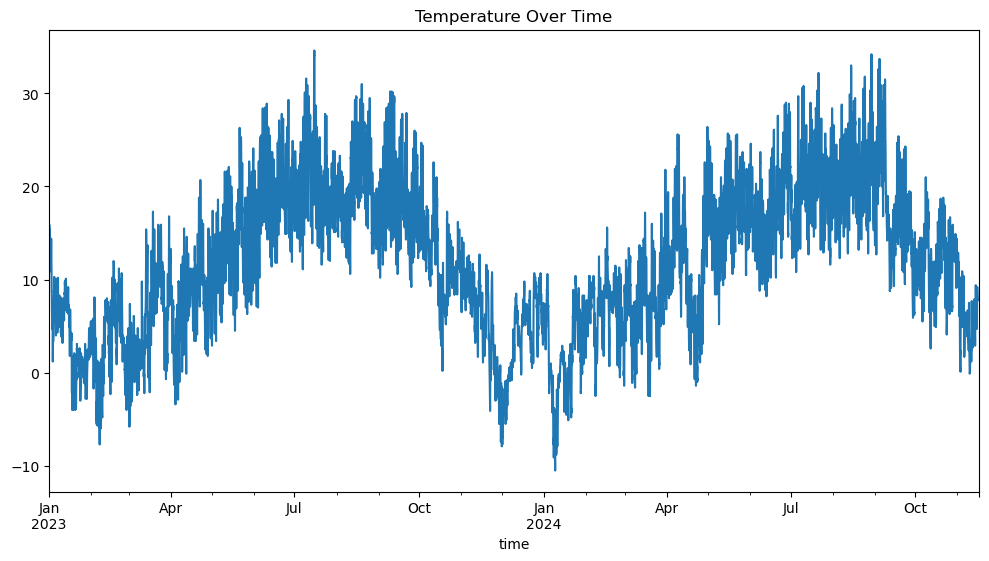

In [ ]:
df_pandas['temperature_2m'].plot(figsize=(12, 6), title='Temperature Over Time')
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_pandas['temperature_2m'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print("The data is not stationary. Differencing is required.")
else:
    print("The data is stationary.")


ADF Statistic: -3.680012623503873
p-value: 0.004403241595104948
The data is stationary.


ACF Plot (for q)

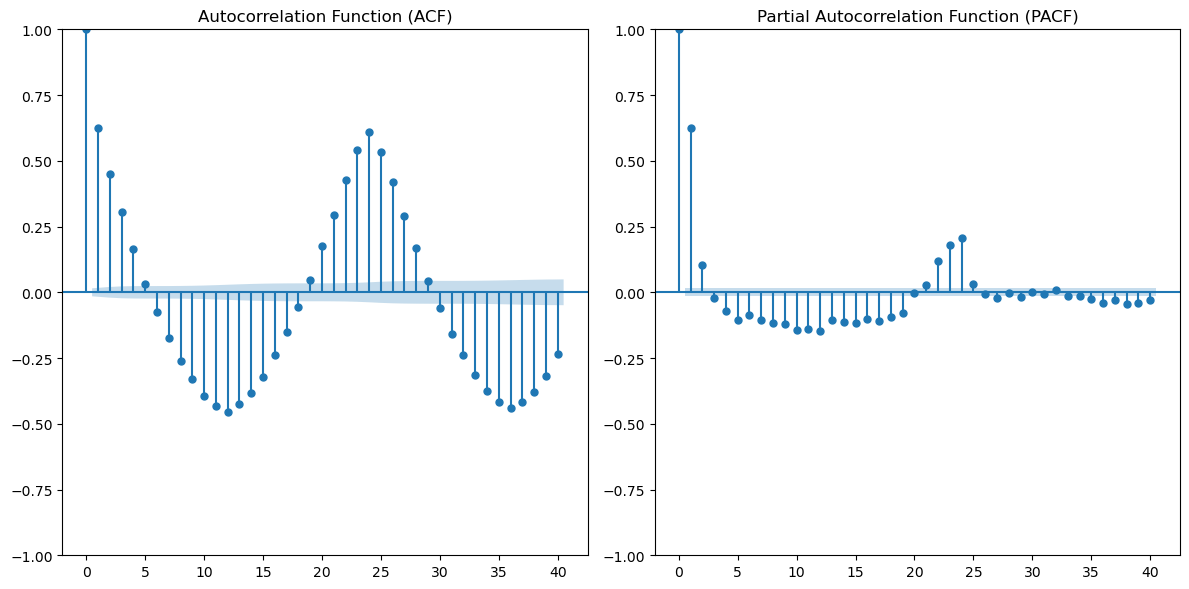

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = df_pandas['temperature_2m'].diff().dropna()

# Plot ACF (for q) and PACF (for p)
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(121)
plot_acf(data, lags=40, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

# PACF Plot
plt.subplot(122)
plot_pacf(data, lags=40, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

In [ ]:
'''import itertools
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None

for param in pdq:
    try:
        model = ARIMA(df_pandas['temperature_2m'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = param
    except:
        continue

print("Best ARIMA Order:", best_order)'''


'import itertools\nimport pandas as pd\nfrom statsmodels.tsa.arima.model import ARIMA\n\np = d = q = range(0, 3)\npdq = list(itertools.product(p, d, q))\n\nbest_aic = float("inf")\nbest_order = None\n\nfor param in pdq:\n    try:\n        model = ARIMA(df_pandas[\'temperature_2m\'], order=param)\n        results = model.fit()\n        if results.aic < best_aic:\n            best_aic = results.aic\n            best_order = param\n    except:\n        continue\n\nprint("Best ARIMA Order:", best_order)'

In [ ]:
model = ARIMA(df_pandas['temperature_2m'], order=(2, 1, 2))
fitted_model = model.fit()

# Summary of the model
print(fitted_model.summary())


/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels

                               SARIMAX Results                                
Dep. Variable:         temperature_2m   No. Observations:                16464
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -17222.492
Date:                Sun, 17 Nov 2024   AIC                          34454.984
Time:                        14:55:57   BIC                          34493.528
Sample:                    01-01-2023   HQIC                         34467.714
                         - 11-16-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8535      0.004    489.042      0.000       1.846       1.861
ar.L2         -0.9229      0.004   -243.231      0.000      -0.930      -0.915
ma.L1         -1.5213      0.006   -243.364      0.0

/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels

                               SARIMAX Results                                
Dep. Variable:         temperature_2m   No. Observations:                16464
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -17222.492
Date:                Sun, 17 Nov 2024   AIC                          34454.984
Time:                        14:56:01   BIC                          34493.528
Sample:                    01-01-2023   HQIC                         34467.714
                         - 11-16-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8535      0.004    489.042      0.000       1.846       1.861
ar.L2         -0.9229      0.004   -243.231      0.000      -0.930      -0.915
ma.L1         -1.5213      0.006   -243.364      0.0

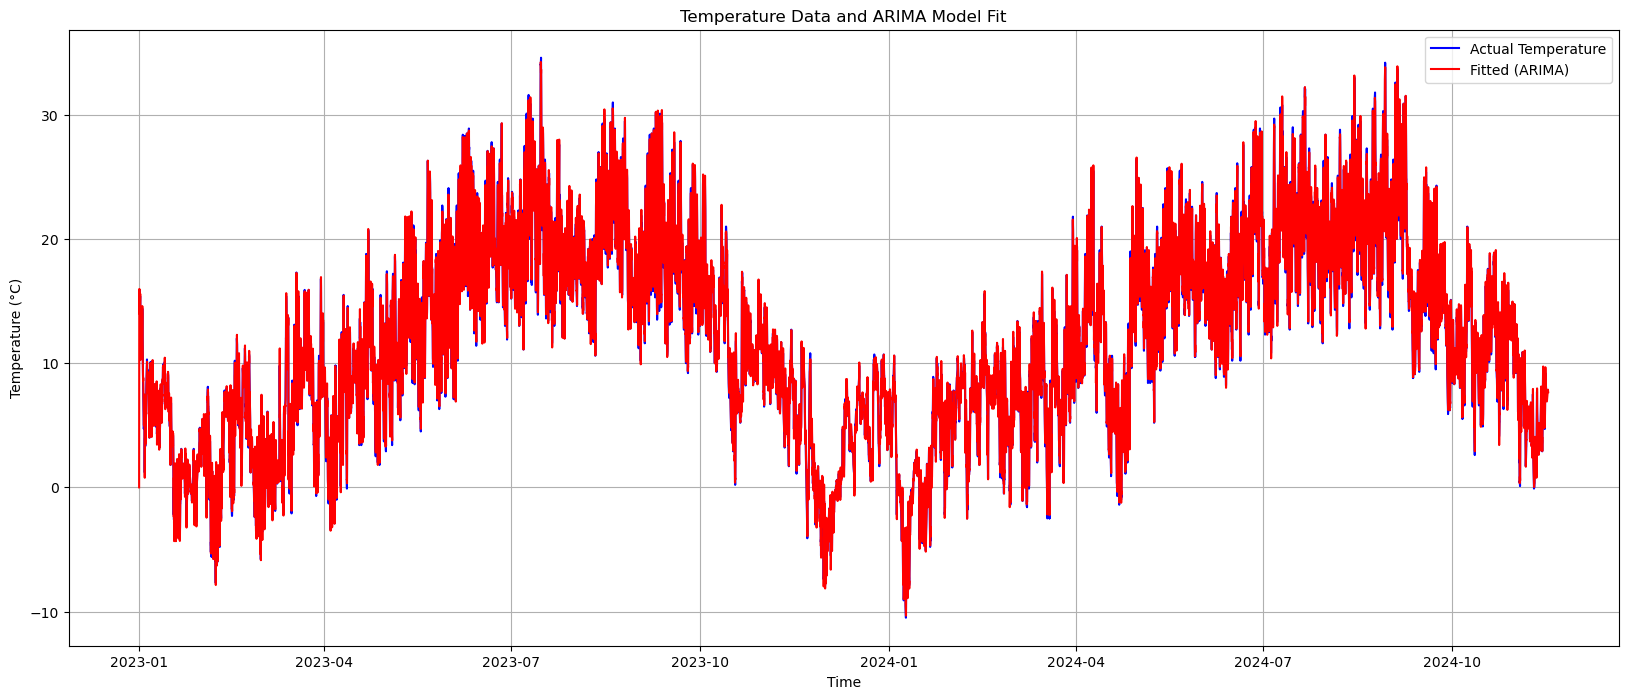

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(df_pandas['temperature_2m'], order=(2, 1, 2))
fitted_model = model.fit()

# Print the summary of the fitted model
print(fitted_model.summary())

# Visualization
fig = plt.figure(figsize=(20, 8))
ax = plt.gca()

# Plot actual data
plt.plot(df_pandas['temperature_2m'], label='Actual', color='blue')

# Plot ARIMA model fitted values
plt.plot(fitted_model.fittedvalues, label='Fitted', color='red')

# Customize plot
ax.legend(['Actual Temperature', 'Fitted (ARIMA)'])
plt.title('Temperature Data and ARIMA Model Fit')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
forecast = fitted_model.forecast(steps=72)  
print("Forecasted values:")
print(forecast)


Forecasted values:
2024-11-17 00:00:00    7.584521
2024-11-17 01:00:00    7.505340
2024-11-17 02:00:00    7.432235
2024-11-17 03:00:00    7.369818
2024-11-17 04:00:00    7.321598
                         ...   
2024-11-19 19:00:00    7.524409
2024-11-19 20:00:00    7.521361
2024-11-19 21:00:00    7.517409
2024-11-19 22:00:00    7.512899
2024-11-19 23:00:00    7.508187
Freq: H, Name: predicted_mean, Length: 72, dtype: float64


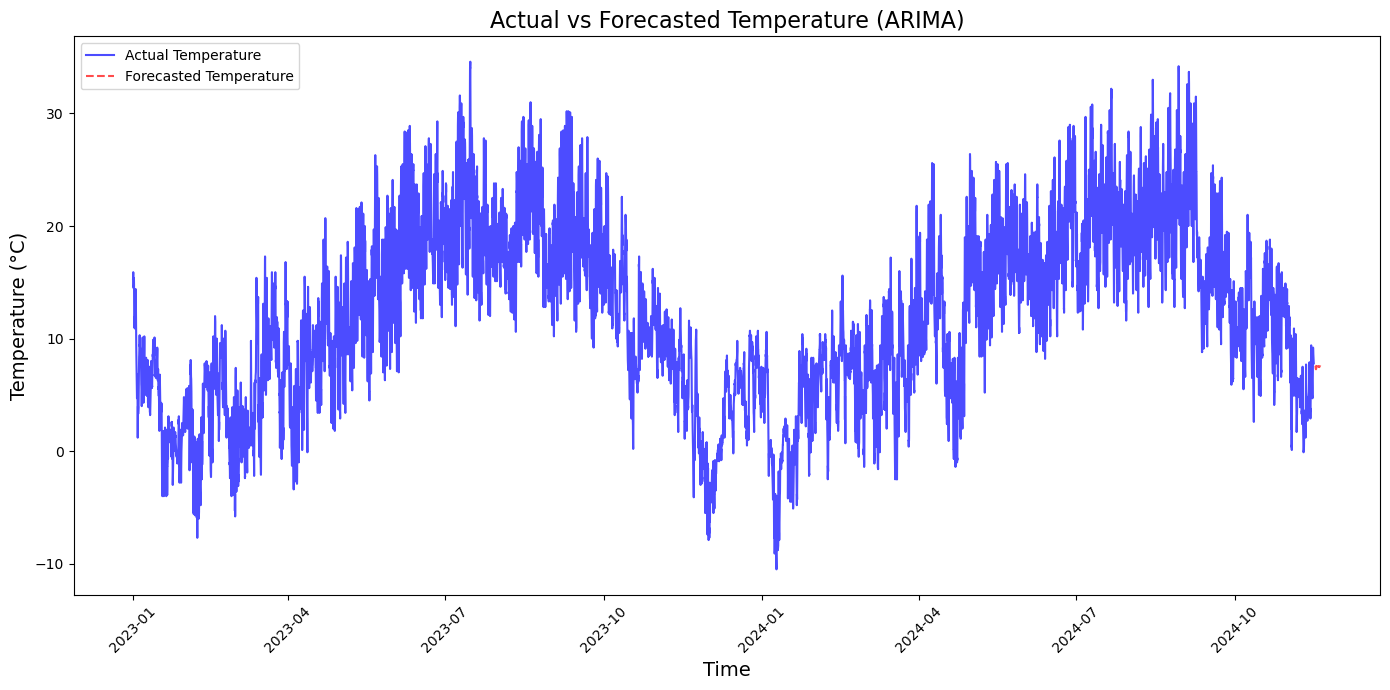

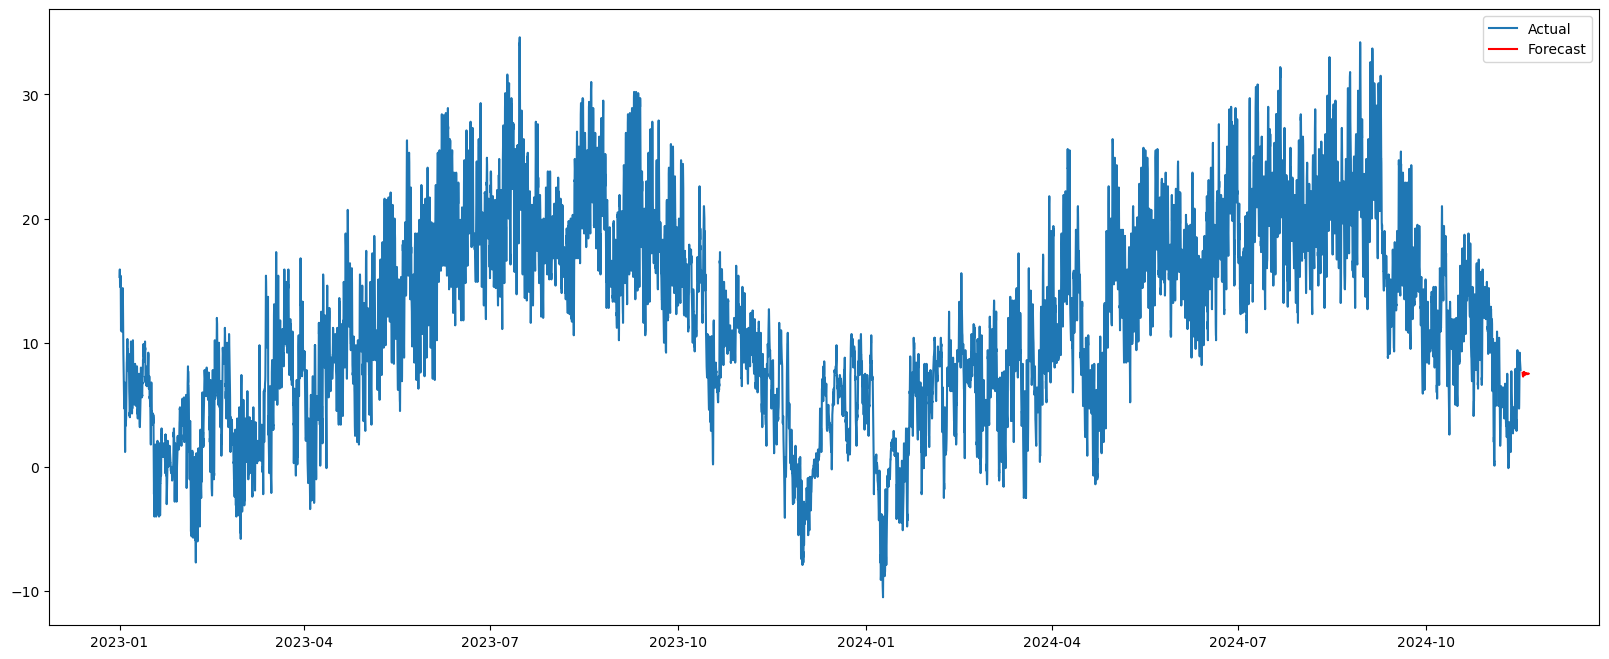

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(df_pandas['temperature_2m'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()


In [ ]:
pip install pmdarima


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(df_pandas['temperature_2m'], 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 12))
sarima_fitted = sarima_model.fit()
print(sarima_fitted.summary())


/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30983D+00    |proj g|=  3.74072D-01


 This problem is unconstrained.



At iterate    5    f=  1.15775D+00    |proj g|=  4.60832D-02

At iterate   10    f=  1.06167D+00    |proj g|=  1.28352D-01

At iterate   15    f=  1.05215D+00    |proj g|=  2.33880D-02

At iterate   20    f=  1.05151D+00    |proj g|=  1.16860D-03

At iterate   25    f=  1.05151D+00    |proj g|=  9.04055D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   9.041D-07   1.052D+00
  F =   1.0515054495649039     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:        

In [ ]:

predictions = fitted_model.forecast(steps=24)

print("Forecasted values:")
print(predictions)

Forecasted values:
2024-11-17 00:00:00    7.584521
2024-11-17 01:00:00    7.505340
2024-11-17 02:00:00    7.432235
2024-11-17 03:00:00    7.369818
2024-11-17 04:00:00    7.321598
2024-11-17 05:00:00    7.289830
2024-11-17 06:00:00    7.275453
2024-11-17 07:00:00    7.278125
2024-11-17 08:00:00    7.296346
2024-11-17 09:00:00    7.327653
2024-11-17 10:00:00    7.368862
2024-11-17 11:00:00    7.416349
2024-11-17 12:00:00    7.466331
2024-11-17 13:00:00    7.515145
2024-11-17 14:00:00    7.559491
2024-11-17 15:00:00    7.596634
2024-11-17 16:00:00    7.624548
2024-11-17 17:00:00    7.642007
2024-11-17 18:00:00    7.648604
2024-11-17 19:00:00    7.644718
2024-11-17 20:00:00    7.631426
2024-11-17 21:00:00    7.610377
2024-11-17 22:00:00    7.583630
2024-11-17 23:00:00    7.553483
Freq: H, Name: predicted_mean, dtype: float64


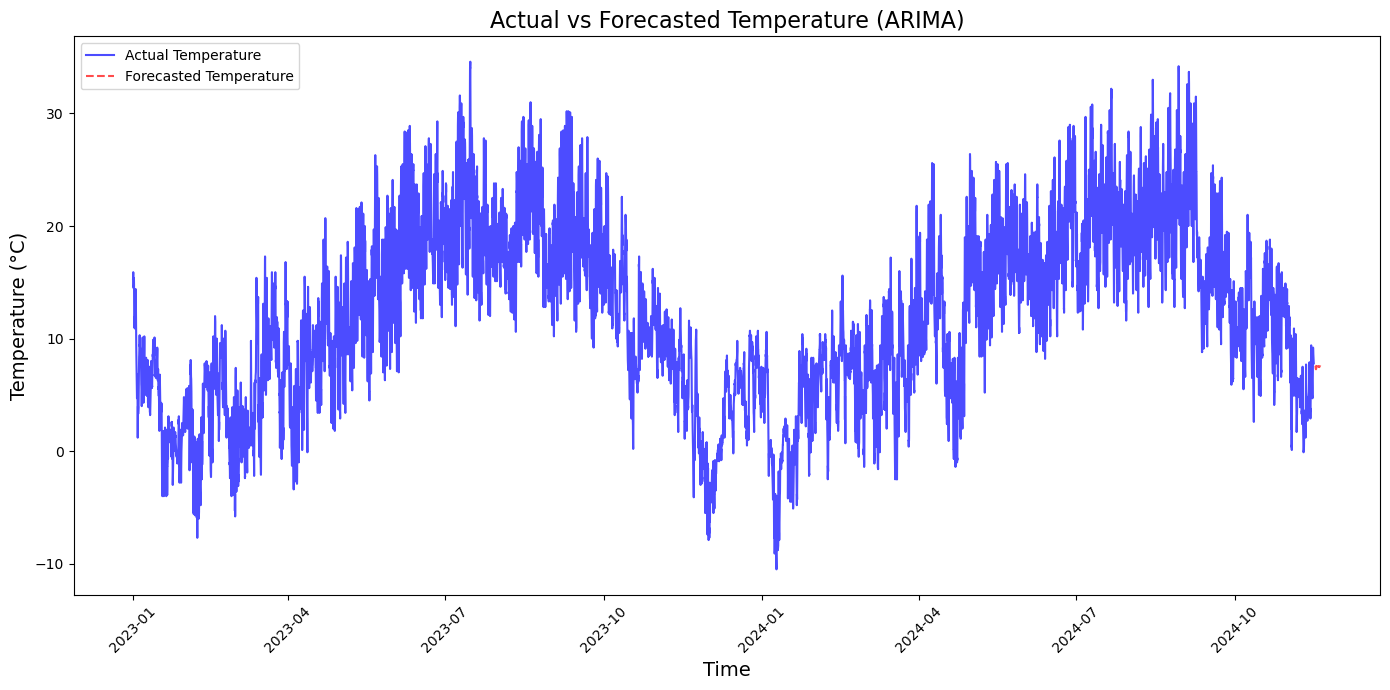

In [ ]:
forecast_steps = 72

forecast_time = pd.date_range(df_pandas.index[-1] + pd.Timedelta(hours=1), periods=forecast_steps, freq='H')

# Convert the forecasted values into a pandas Series
forecast_series = pd.Series(forecast, index=forecast_time)

# Plot actual data and forecasted data
plt.figure(figsize=(14, 7))
plt.plot(df_pandas.index, df_pandas['temperature_2m'], label='Actual Temperature', color='blue', alpha=0.7)
plt.plot(forecast_series.index, forecast_series.values, label='Forecasted Temperature', color='red', linestyle='--', alpha=0.7)

# Add labels and title
plt.title('Actual vs Forecasted Temperature (ARIMA)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


Daily forecasting

Data fetched successfully!


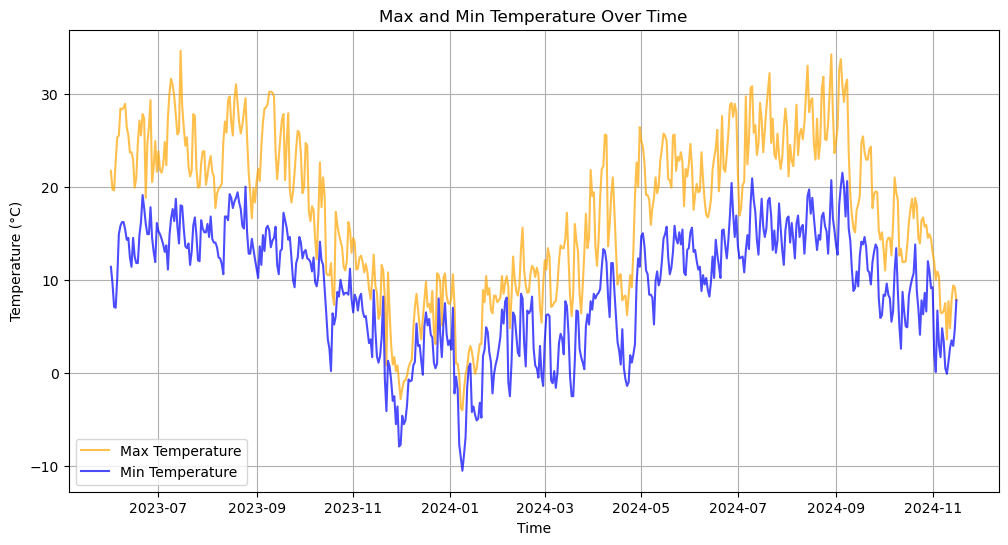

                               SARIMAX Results                                
Dep. Variable:     temperature_2m_max   No. Observations:                  535
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1309.822
Date:                Sun, 17 Nov 2024   AIC                           2629.644
Time:                        15:06:50   BIC                           2651.046
Sample:                    06-01-2023   HQIC                          2638.019
                         - 11-16-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3316      0.233      1.421      0.155      -0.126       0.789
ar.L2          0.1481      0.188      0.789      0.430      -0.220       0.516
ma.L1         -0.4305      0.223     -1.928      0.0

/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import json

# Fetch daily data from Open-Meteo API
url = """https://archive-api.open-meteo.com/v1/era5?latitude=52.52&longitude=13.41&start_date=2023-06-01&end_date=2024-11-16&daily=temperature_2m_max,temperature_2m_min"""
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    print("Data fetched successfully!")
else:
    print("Failed to fetch data.")
    exit()

# Parse JSON response
data_json = response.json()

# Create a DataFrame from the JSON data
df_json = {}
for item in list(data_json['daily_units'].keys()):
    df_json[item] = data_json['daily'][item]

df_pandas = pd.DataFrame(df_json)

# Convert the 'time' column to datetime format and set it as index
df_pandas['time'] = pd.to_datetime(df_pandas['time'])
df_pandas.set_index('time', inplace=True)

# Plot the daily temperature data (max and min temperatures)
plt.figure(figsize=(12, 6))
plt.plot(df_pandas.index, df_pandas['temperature_2m_max'], label='Max Temperature', color='orange', alpha=0.7)
plt.plot(df_pandas.index, df_pandas['temperature_2m_min'], label='Min Temperature', color='blue', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Max and Min Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Fit the ARIMA model on the max temperature (you can also fit on min or average)
model = ARIMA(df_pandas['temperature_2m_max'], order=(2, 1, 2))
fitted_model = model.fit()

# Print the summary of the fitted ARIMA model
print(fitted_model.summary())

# Forecast the next 30 days (or any number of days)



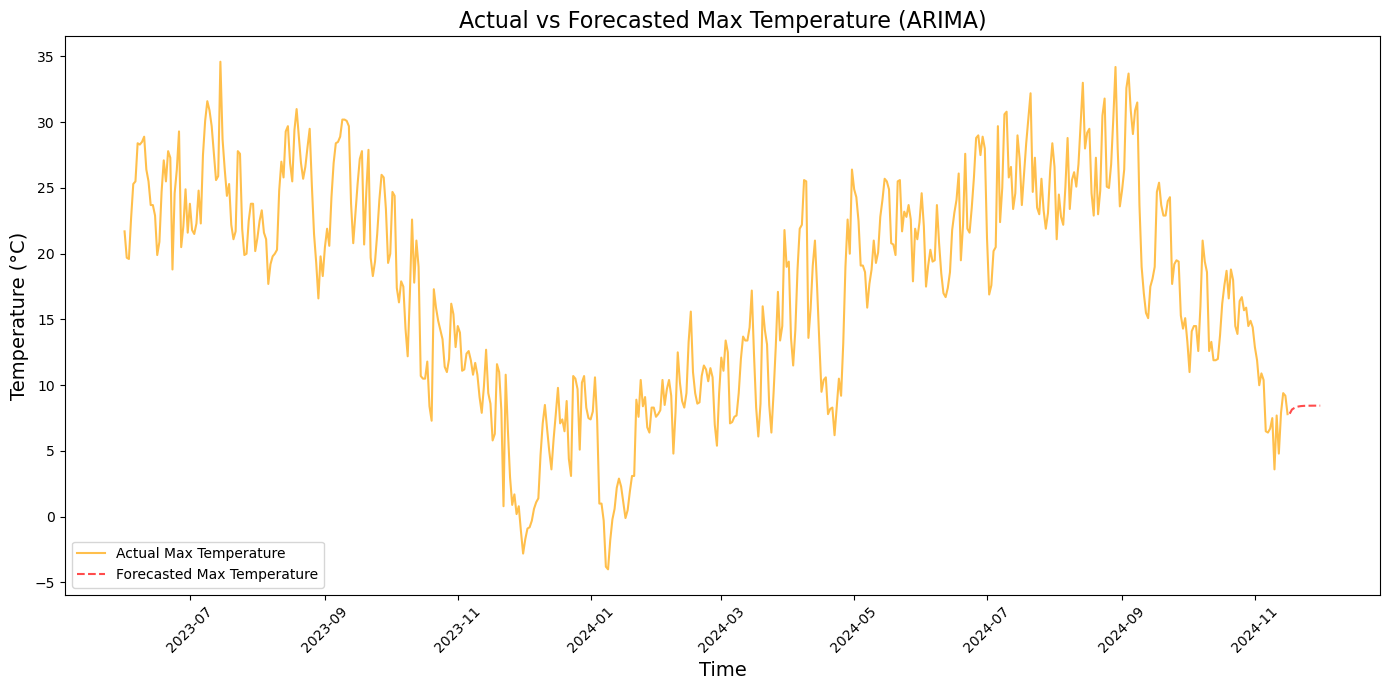

In [ ]:
forecast_steps = 15
forecast = fitted_model.forecast(steps=forecast_steps)

# Create a new time range for the forecasted values
forecast_time = pd.date_range(df_pandas.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Convert the forecasted values into a pandas Series
forecast_series = pd.Series(forecast, index=forecast_time)

# Plot actual data and forecasted data
plt.figure(figsize=(14, 7))
plt.plot(df_pandas.index, df_pandas['temperature_2m_max'], label='Actual Max Temperature', color='orange', alpha=0.7)
plt.plot(forecast_series.index, forecast_series.values, label='Forecasted Max Temperature', color='red', linestyle='--', alpha=0.7)

# Add labels and title
plt.title('Actual vs Forecasted Max Temperature (ARIMA)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()